# Maven MegaMart New Acquisition Analysis


* First, read in the transactions data.

* Read in the only columns `household_key`, `BASKET_ID`, `DAY`, `PRODUCT_ID`, `QUANTITY`, and `SALES_VALUE`.

* Convert `DAY`, `QUANTITY`, and `PRODUCT_ID` to the smallest appropriate integer types.


In [47]:
import pandas as pd
import numpy as np

In [48]:
path = "../project_data/project_transactions.csv"

# specify columns to keep
cols = ["household_key", "BASKET_ID", "DAY", "PRODUCT_ID", "QUANTITY", "SALES_VALUE"]

# specify datatypes to convert
dtypes = {"DAY": "Int16", "QUANTITY": "Int32", "PRODUCT_ID": "Int32"}

transactions = pd.read_csv(path,
                           dtype=dtypes,
                           usecols=cols
                          )

In [49]:
# stats on numeric columns
transactions.describe().round()


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE
count,2146311.0,2.146311e+06,2146311.0,2146311.0,2146311.0,2146311.0
mean,1056.0,3.404897e+10,390.0,2884715.0,101.0,3.0
std,605.0,4.723748e+09,190.0,3831949.0,1152.0,4.0
min,1.0,2.698490e+10,1.0,25671.0,0.0,0.0
25%,548.0,3.040798e+10,229.0,917231.0,1.0,1.0
50%,1042.0,3.281176e+10,392.0,1027960.0,1.0,2.0
75%,1581.0,4.012804e+10,555.0,1132771.0,1.0,3.0
max,2099.0,4.230536e+10,711.0,18316298.0,89638.0,840.0


In [50]:
transactions.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   household_key  int64  
 1   BASKET_ID      int64  
 2   DAY            Int16  
 3   PRODUCT_ID     Int32  
 4   QUANTITY       Int32  
 5   SALES_VALUE    float64
dtypes: Int16(1), Int32(2), float64(1), int64(2)
memory usage: 75.7 MB


In [51]:
transactions.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE
0,1364,26984896261,1,842930,1,2.19
1,1364,26984896261,1,897044,1,2.99
2,1364,26984896261,1,920955,1,3.09
3,1364,26984896261,1,937406,1,2.50
4,1364,26984896261,1,981760,1,0.60


In [52]:
# There's no date column. Only a day column with int values.
# Since I know the data is from 2016, I will start with '2016-01-01' then add the int days and assign that as date.
transactions = (transactions
                .assign(date = 
                        (pd.to_datetime("2016", format='%Y') # 2016-01-01
                        + pd.to_timedelta(transactions["DAY"].sub(1).astype(str) + " days")) # adds "x days"
                       )
                .drop(["DAY"], axis=1) # drop day column, no longer needed
               )

In [53]:
transactions.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   household_key  int64         
 1   BASKET_ID      int64         
 2   PRODUCT_ID     Int32         
 3   QUANTITY       Int32         
 4   SALES_VALUE    float64       
 5   date           datetime64[ns]
dtypes: Int32(2), datetime64[ns](1), float64(1), int64(2)
memory usage: 86.0 MB


In [54]:
transactions.head()

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,date
0,1364,26984896261,842930,1,2.19,2016-01-01
1,1364,26984896261,897044,1,2.99,2016-01-01
2,1364,26984896261,920955,1,3.09,2016-01-01
3,1364,26984896261,937406,1,2.50,2016-01-01
4,1364,26984896261,981760,1,0.60,2016-01-01


## TIME BASED ANALYSIS

* Plot the sum of sales by month. Are sales growing over time?
* Next, plot the same series after filtering down to dates April 2016 and October 2017.
* Then, plot the sum of sales 2016 vs the 2017 sales.
* Then, plot total sales by day of week.

In [55]:
# Sales by month
(transactions.set_index("date")
 .loc[:, "SALES_VALUE"]
 .resample("M")
 .sum()
)

date
2016-01-31     46557.97
2016-02-29     97315.16
2016-03-31    185521.82
2016-04-30    267801.38
2016-05-31    298319.14
2016-06-30    288952.45
2016-07-31    296488.02
2016-08-31    303951.35
2016-09-30    302040.56
2016-10-31    309962.42
2016-11-30    304764.41
2016-12-31    310456.27
2017-01-31    320301.20
2017-02-28    298058.26
2017-03-31    325511.23
2017-04-30    308786.99
2017-05-31    328829.68
2017-06-30    304792.96
2017-07-31    312853.52
2017-08-31    341670.16
2017-09-30    317498.59
2017-10-31    346065.23
2017-11-30    335458.18
2017-12-31    114286.55
Freq: M, Name: SALES_VALUE, dtype: float64

<Axes: xlabel='date'>

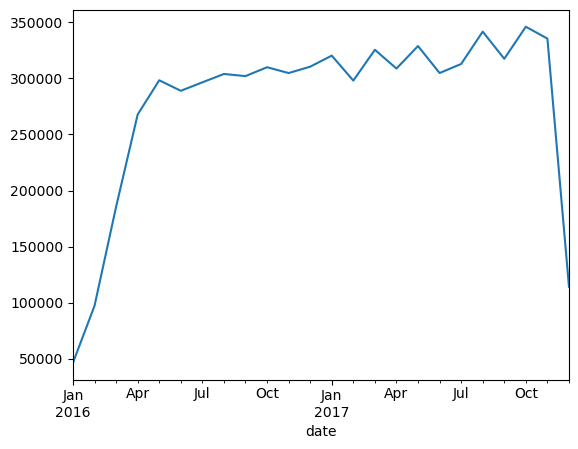

In [56]:
(transactions.set_index("date")
 .loc[:, "SALES_VALUE"]
 .resample("M")
 .sum()
 .plot()
)

# Looks like data is tapered at the ends. Possible the sales data is not fully included at those ends.
# Better to filter to months where the data is fully populated.

<Axes: xlabel='date'>

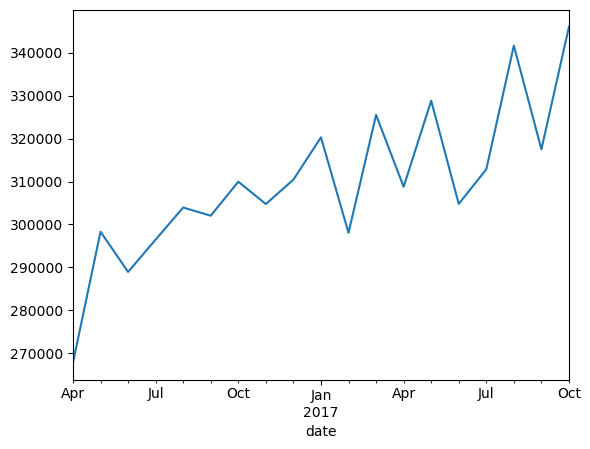

In [57]:
(transactions
 .set_index("date")
 .sort_index()
 .loc["2016-04":"2017-10", "SALES_VALUE"]
 .resample("M")
 .sum()
 .plot())

# Really nice growth month to month. Acquisition candidate.

In [58]:
# Let's compare sales with year prior. We'll be shifting the values 12 rows/months

(transactions
 .set_index("date")
 .loc[:, ["SALES_VALUE"]]
 .resample("M")
 .agg(
     sum_sales = ("SALES_VALUE", "sum"))
 .assign(year_prior = lambda x: x["sum_sales"].shift(12))
#  .loc["2017"]
#  .plot()
)

,sum_sales,year_prior
date,,
2016-01-31,46557.97,NaN
2016-02-29,97315.16,NaN
2016-03-31,185521.82,NaN
2016-04-30,267801.38,NaN
2016-05-31,298319.14,NaN
2016-06-30,288952.45,NaN
2016-07-31,296488.02,NaN
2016-08-31,303951.35,NaN
2016-09-30,302040.56,NaN


<Axes: xlabel='date'>

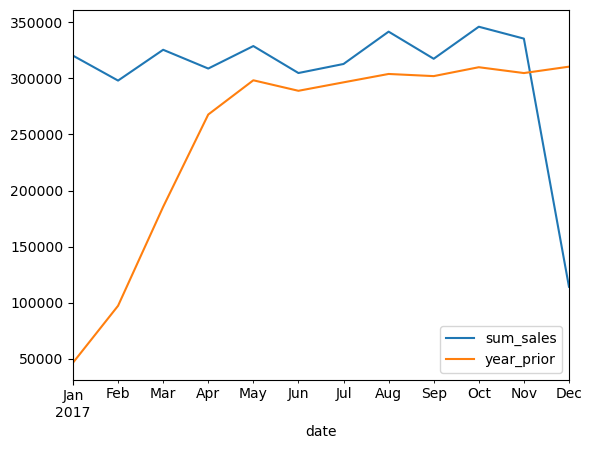

In [59]:
(transactions
 .set_index("date")
 .loc[:, ["SALES_VALUE"]]
 .resample("M")
 .agg(
     sum_sales = ("SALES_VALUE", "sum"))
 .assign(year_prior = lambda x: x["sum_sales"].shift(12))
 .loc["2017"]
 .plot()
)

# I still don't like the beginning and end data that tapers. But it'll do for now.
# Best values to compare is Apr - Oct (2016 vs 2017). ~50k gap comparing those months

<Axes: xlabel='date'>

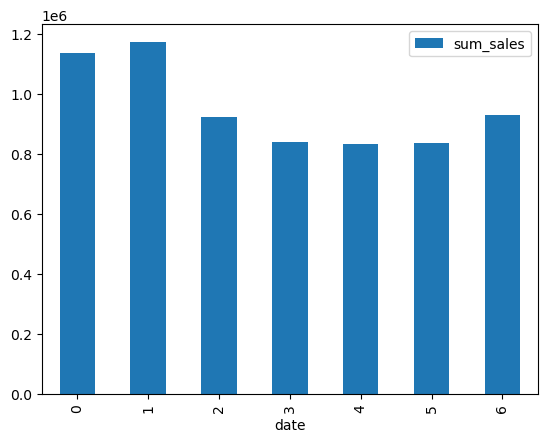

In [60]:
# Let's look at sales by day of week.
(transactions
 .groupby(transactions["date"].dt.dayofweek)
 .agg(
     sum_sales = ("SALES_VALUE", "sum"))
 .plot.bar()
)

# Mon & Tue has highest sales in this data? Possible this is actually Sat & Sun.
# This is likely due to my need to convert "DAY" column to "date" column and assuming "DAY" == 1 --> "2016-01-01"
# Consult with data subject matter expert and get more details.

# DEMOGRAPHICS

* Read in the `hh_demographic.csv` file, Then group the transactions table by household_id, and calculate the sum of SALES VALUE by household.


* Once you've done that, join the demographics DataFrame to the transactions table. Since we're interested in analyzing the demographic data we have, make sure not to include rows from transactions that don't match.


* Plot the sum of sales by age_desc and income_desc.


* Then, create a pivot table of the mean household sales by `AGE_DESC` and `HH_COMP_DESC`. Which of our demographics have the highest average sales?


In [61]:
# Reading in columns of focus.
dem_cols = ["AGE_DESC", "INCOME_DESC", "household_key", "HH_COMP_DESC"]

# Convert the object columns here to category dtype. HUGE memory savings.
dem_dtypes = {"AGE_DESC": "category", "INCOME_DESC": "category", "HH_COMP_DESC":"category"}

demographics = pd.read_csv('../project_data/hh_demographic.csv',
                          usecols=dem_cols,
                          dtype=dem_dtypes
                          )

In [62]:
demographics.head()

,AGE_DESC,INCOME_DESC,HH_COMP_DESC,household_key
0,65+,35-49K,2 Adults No Kids,1
1,45-54,50-74K,2 Adults No Kids,7
2,25-34,25-34K,2 Adults Kids,8
3,25-34,75-99K,2 Adults Kids,13
4,45-54,50-74K,Single Female,16


In [63]:
demographics.info(memory_usage="deep")
# Looks good. No null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   AGE_DESC       801 non-null    category
 1   INCOME_DESC    801 non-null    category
 2   HH_COMP_DESC   801 non-null    category
 3   household_key  801 non-null    int64   
dtypes: category(3), int64(1)
memory usage: 10.9 KB


In [64]:
household_sales = (transactions
                   .groupby("household_key")
                   .agg(
                       sum_sales = ("SALES_VALUE", "sum"))
                  )

household_sales

,sum_sales
household_key,
1,4330.16
2,1954.34
3,2653.21
4,1200.11
5,779.06
...,...
2095,3790.49
2096,1301.65
2097,8823.83


In [65]:
# Inner join household sales and demographics table on household_key

household_sales_demo = (household_sales.merge(demographics, 
                             how="inner",
                             left_on='household_key',
                             right_on="household_key",
                             )
                       )

In [66]:
household_sales_demo.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   household_key  668 non-null    int64   
 1   sum_sales      668 non-null    float64 
 2   AGE_DESC       668 non-null    category
 3   INCOME_DESC    668 non-null    category
 4   HH_COMP_DESC   668 non-null    category
dtypes: category(3), float64(1), int64(1)
memory usage: 14.7 KB


In [67]:
household_sales_demo.head()

,household_key,sum_sales,AGE_DESC,INCOME_DESC,HH_COMP_DESC
0,1,4330.16,65+,35-49K,2 Adults No Kids
1,7,3400.05,45-54,50-74K,2 Adults No Kids
2,8,5534.97,25-34,25-34K,2 Adults Kids
3,13,13190.92,25-34,75-99K,2 Adults Kids
4,16,1512.02,45-54,50-74K,Single Female


<Axes: xlabel='AGE_DESC'>

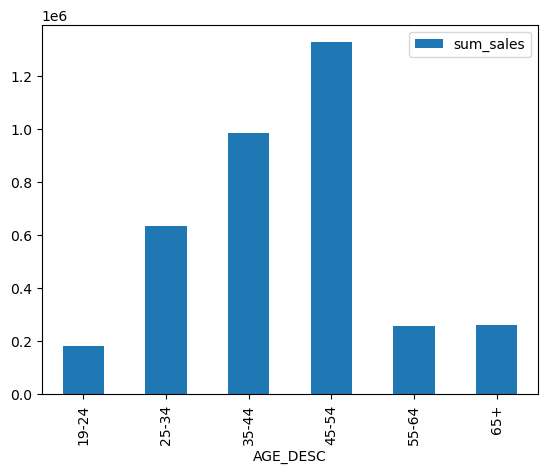

In [68]:
# Calculate sum of sales by age group

(household_sales_demo
.groupby(["AGE_DESC"], observed=False)
.agg(
    sum_sales = ("sum_sales", "sum"))
.plot.bar()
)

# Consumer spending power tend to peek in middle age. Not surprising.

<Axes: xlabel='INCOME_DESC'>

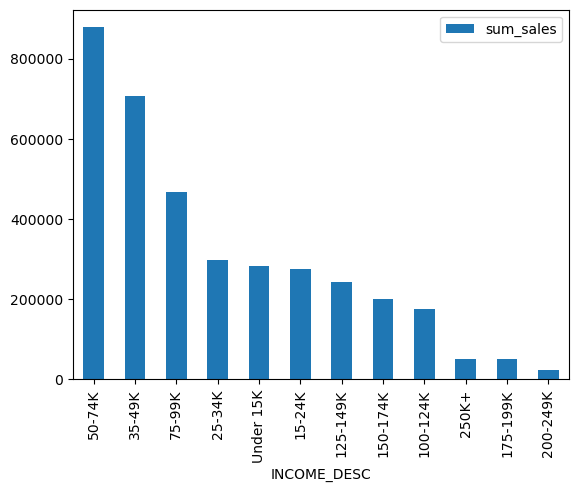

In [69]:
# Calculate sum of sales by income, ordered by magnitude

(household_sales_demo
 .groupby(["INCOME_DESC"], observed=False)
.agg(
    sum_sales = ("sum_sales", "sum"))
 .sort_values("sum_sales", ascending=False)
 .plot.bar())

# I would expect our top 4 household demographics seem like a reflection U.S. Population Salaries.
# Good to see there is a healthy contribution from some low income brackets as well.
# Considering this is a discount retailer. Very healthy cluster of discount shoppers.

In [70]:
# Calculate mean household spend by Age Description and HH Composition
# Format with a heatmap across all cells

(household_sales_demo.pivot_table(index="AGE_DESC", 
                 columns="HH_COMP_DESC",
                 values="sum_sales",
                 aggfunc="mean",
                 margins=True)
 .style.background_gradient(cmap="RdYlGn", axis=None)
)

# Households with 2 Adults w/ kids tend to have the highest spend across all of our households.
# Average spending reflected across 35 to 44, 45 to 54 particularly among houses with kids.
# Steep drop off when household doesn't have kids.
# Single Males tend to spend the least. Probably not buying the highest margin items in our store.

# This will allow us to get better ROI on our marketing.
# We really like to see that we have high spend among shoppers with kids.


HH_COMP_DESC,1 Adult Kids,2 Adults Kids,2 Adults No Kids,Single Female,Single Male,Unknown,All
AGE_DESC,,,,,,,
19-24,7268.796667,5428.945000,4020.800000,4576.095556,3216.835000,4911.275000,4692.077692
25-34,5512.196875,5753.973514,5638.515833,4807.440588,4909.522381,7356.270000,5435.517521
35-44,6297.737778,6691.772264,6260.412444,6015.192069,4844.192000,4227.691818,6090.556728
45-54,6632.569167,6610.484490,5839.527027,4549.365405,4636.637083,4843.995682,5534.879958
55-64,3064.870000,4695.655000,5752.413684,4816.148462,3922.546250,7973.750000,5168.924200
65+,4040.810000,5536.866667,4614.108571,4059.699412,3871.556000,2879.290000,4340.936500
All,6032.802143,6280.069103,5599.857756,4895.928361,4544.646750,4936.127778,5468.398743


In [71]:
# delete dfs we won't use anymore

del [household_sales_demo, household_sales]

# PRODUCT DEMOGRAPHICS

* Join the product DataFrame to transactions and demographics tables, performing an inner join when joining both tables.

* Finally, pivot the fully joined dataframe by AGE_DESC and DEPARTMENT, calculating the sum of sales. Which category does our youngest demographic perform well in?



In [72]:
# specify columns to use
product_cols = ["PRODUCT_ID", "DEPARTMENT"]

# specify datatypes for each column
product_dtypes = {"PRODUCT_ID": "Int32", "DEPARTMENT": "category"}

product = pd.read_csv('../project_data/product.csv',
                     usecols=product_cols,
                     dtype=product_dtypes
                     )

In [73]:
product.dtypes

PRODUCT_ID       Int32
DEPARTMENT    category
dtype: object

In [74]:
# Inner join all 3 tables.
trans_demo_dept = (transactions
                  .merge(demographics, 
                         how="inner",
                         left_on='household_key',
                         right_on="household_key",)
                  .merge(product,
                         how="inner",
                         left_on="PRODUCT_ID",
                         right_on="PRODUCT_ID")
             
             )

In [76]:
trans_demo_dept.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161575 entries, 0 to 1161574
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   household_key  1161575 non-null  int64         
 1   BASKET_ID      1161575 non-null  int64         
 2   PRODUCT_ID     1161575 non-null  Int32         
 3   QUANTITY       1161575 non-null  Int32         
 4   SALES_VALUE    1161575 non-null  float64       
 5   date           1161575 non-null  datetime64[ns]
 6   AGE_DESC       1161575 non-null  category      
 7   INCOME_DESC    1161575 non-null  category      
 8   HH_COMP_DESC   1161575 non-null  category      
 9   DEPARTMENT     1161575 non-null  category      
dtypes: Int32(2), category(4), datetime64[ns](1), float64(1), int64(2)
memory usage: 51.0 MB


In [79]:
# What product category is each age group strong in?

(trans_demo_dept.pivot_table(index="DEPARTMENT",
                            columns="AGE_DESC",
                            values="SALES_VALUE",
                            aggfunc="sum")
 .style.background_gradient(cmap="RdYlGn", axis=1))

# Heatmap ACROSS COLUMNS to get a sense of what product category each age group is strong in.
# 45-54 age group dominates most product categories.
# Interestingly 1 product category our young demographic is strong in is in "SPIRITS". Marketing insight.

AGE_DESC,19-24,25-34,35-44,45-54,55-64,65+
DEPARTMENT,,,,,,
,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AUTOMOTIVE,11.640000,21.250000,72.580000,55.920000,0.000000,16.370000
CHARITABLE CONT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHEF SHOPPE,81.300000,134.160000,348.530000,418.240000,80.860000,149.240000
CNTRL/STORE SUP,2.000000,0.000000,1.000000,9.950000,2.000000,0.100000
COSMETICS,698.630000,2273.030000,4362.020000,5187.570000,986.260000,600.900000
COUP/STR & MFG,7.490000,48.420000,121.200000,154.550000,40.680000,20.490000
DAIRY DELI,3.800000,3.850000,7.390000,16.750000,3.140000,1.940000
DELI,4043.300000,18181.940000,34577.290000,44334.220000,9850.540000,10462.330000


# EXPORT

Finally, export your pivot table to an excel file. Make sure to provide a sheet name.

In [80]:
# Call to_excel on pivot table above - note the formatting gets passed to excel too!
(trans_demo_dept.pivot_table(index="DEPARTMENT",
                            columns="AGE_DESC",
                            values="SALES_VALUE",
                            aggfunc="sum")
 .style.background_gradient(cmap="RdYlGn", axis=1)
 .to_excel("demographic_category_sales.xlsx", sheet_name="sales_pivot")
)